# Notebook 03 — Modelling

# 1. Imports

In [174]:
# Standard library
import sys
import warnings
from pathlib import Path

project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Data handling
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Preprocessing / feature engineering
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

# Modeling
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV, Ridge, RidgeCV, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

# Model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

# Display
from IPython.display import display, HTML

import joblib
from utils.helpers import plot_residuals, evaluate_regression_metrics_df, plot_residuals_vs_fitted

In [175]:
print("Current working directory:", Path.cwd())

Current working directory: c:\Users\gabri\Documents\Dokumenty\job-satisfaction-analysis\notebooks


# 2. Settings / Configuration

In [176]:
warnings.filterwarnings("ignore")
seed=42
display(HTML("<style>.output_scroll { height: auto !important; }</style>"))

# 3. Loading data

In [177]:
data_path = Path("../data/processed") / "clean_data.csv"

if data_path.exists():
    df_clean = pd.read_csv(data_path)
else:
    print(f"Data file not found at {data_path}.")

In [178]:
df_clean.head()

,id,wiek,m1,woj,m2,g8,wykszt_7k,j1_02,j1_03,j1_04,...,j3_13,m9_13k,m9d,m13,o1_1,o1_2,o1_3,j1_01,satisfaction,generation
0,6591,19,2002,10,0,3,3,4,5,5,...,2,7.0,3000.0,5.0,2600,7500,14000,4,4,Z
1,6592,37,1984,10,1,2,7,2,3,4,...,4,3.0,1100.0,4.0,2500,3000,4500,2,2,M
2,6594,24,1997,14,1,2,6,5,5,5,...,5,9.0,4800.0,5.0,6000,7500,10000,5,4,Z
3,6598,49,1972,24,1,2,5,3,5,5,...,5,10.0,5000.0,4.0,3500,5500,6500,4,4,X
4,6601,46,1975,22,1,2,7,3,5,5,...,2,10.0,5000.0,30.5,-7,-7,-7,2,2,X


# 4. Defining predictors and target

In [179]:
likert_predictors = [f"j1_{str(i).zfill(2)}" for i in range(1, 11)]
likert_predictors += [f"j3_{str(i).zfill(2)}" for i in range(1, 14)]
likert_predictors += ["m13"]  

salary_predictor = ["m9d"]

In [180]:
y = df_clean['satisfaction']

In [181]:
X_likert = df_clean[likert_predictors]
X_all = df_clean[likert_predictors + salary_predictor]

In [182]:
X_train_likert, X_test_likert, y_train, y_test = train_test_split(X_likert, y, test_size=0.2, random_state=42)

In [183]:
X_train_all, X_test_all, y_train, y_test = train_test_split(X_all, y, test_size=0.2, random_state=42)

In [184]:
print(df_clean['m9d'].describe()) 
print((df_clean['m9d'] < 0).sum())

count     1201.000000
mean      7544.574925
std       7650.378375
min         30.500000
25%       2800.000000
50%       3750.000000
75%       7000.000000
max      30000.000000
Name: m9d, dtype: float64
0


# 5. Scaling and data preprocessing

In [185]:
salary_pipeline = Pipeline([
    ('log', FunctionTransformer(np.log1p, validate=False)), 
    ('scale', StandardScaler())
])

In [186]:
preprocessor_likert = ColumnTransformer(
    transformers=[
        ('likert_scaler', StandardScaler(), likert_predictors),
    ])

In [187]:
preprocessor_all = ColumnTransformer(
    transformers=[
        ('likert_scaler', StandardScaler(), likert_predictors),
        ('salary_scaler', salary_pipeline, salary_predictor)
    ])

In [188]:
X_train_l_scaled = preprocessor_likert.fit_transform(X_train_likert)
X_train_a_scaled = preprocessor_all.fit_transform(X_train_all)
X_test_l_scaled = preprocessor_likert.transform(X_test_likert)
X_test_a_scaled = preprocessor_all.transform(X_test_all)

In [189]:
print("Mean of each scaled column:", np.mean(X_train_l_scaled, axis=0).round(2))
print("Standard deviation of each scaled column:", np.std(X_train_l_scaled, axis=0).round(2))

Mean of each scaled column: [ 0. -0.  0. -0. -0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0.  0.  0.  0.
 -0. -0.  0. -0.  0.  0.]
Standard deviation of each scaled column: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [190]:
print("Mean of each scaled column:", np.mean(X_train_a_scaled, axis=0).round(2))
print("Standard deviation of each scaled column:", np.std(X_train_a_scaled, axis=0).round(2))

Mean of each scaled column: [ 0. -0.  0. -0. -0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0.  0.  0.  0.
 -0. -0.  0. -0.  0.  0.  0.]
Standard deviation of each scaled column: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]


# 6. Model building and evaluation

Linear Regression

In [191]:
model_reg_l = LinearRegression()
model_reg_l.fit(X_train_l_scaled, y_train)
y_pred_reg_l = model_reg_l.predict(X_test_l_scaled)

In [192]:
evaluate_regression_metrics_df(y_test, y_pred_reg_l)

,Metryka,Wartość
0,MSE,0.5631
1,RMSE,0.7504
2,RMSPE [%],33.6404
3,MAE,0.4378
4,MAPE [%],16.6890
5,R²,0.3151
6,Korelacja Pearsona,0.5616


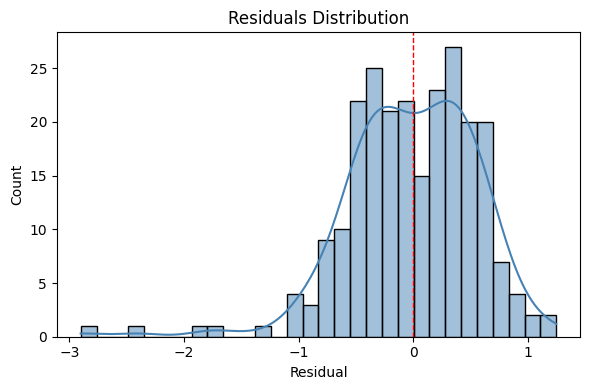

In [193]:
plot_residuals(y_test, y_pred_reg_l)

In [194]:
model_reg_a = LinearRegression()
model_reg_a.fit(X_train_a_scaled, y_train)
y_pred_reg_a = model_reg_a.predict(X_test_a_scaled)

In [195]:
evaluate_regression_metrics_df(y_test, y_pred_reg_a)

,Metryka,Wartość
0,MSE,0.5628
1,RMSE,0.7502
2,RMSPE [%],33.6942
3,MAE,0.4373
4,MAPE [%],16.7000
5,R²,0.3157
6,Korelacja Pearsona,0.5622


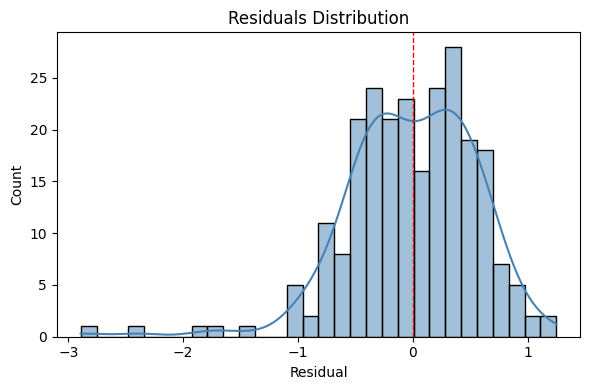

In [196]:
plot_residuals(y_test, y_pred_reg_a)

Random Forest Regressor

In [197]:
model_rf_l = RandomForestRegressor(random_state=42)
model_rf_l.fit(X_train_l_scaled, y_train)
y_pred_rf_l = model_rf_l.predict(X_test_l_scaled)

In [198]:
evaluate_regression_metrics_df(y_test, y_pred_rf_l)

,Metryka,Wartość
0,MSE,0.5905
1,RMSE,0.7684
2,RMSPE [%],35.1497
3,MAE,0.4529
4,MAPE [%],17.2954
5,R²,0.2468
6,Korelacja Pearsona,0.5024


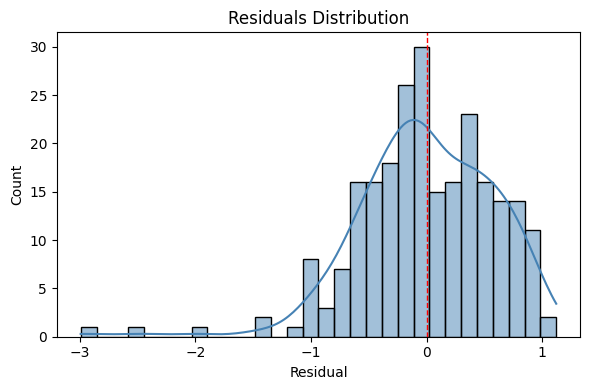

In [199]:
plot_residuals(y_test, y_pred_rf_l)

In [200]:
model_rf_a = RandomForestRegressor(random_state=42)
model_rf_a.fit(X_train_a_scaled, y_train)
y_pred_rf_a = model_rf_a.predict(X_test_a_scaled)

In [201]:
evaluate_regression_metrics_df(y_test, y_pred_rf_a)

,Metryka,Wartość
0,MSE,0.5821
1,RMSE,0.7629
2,RMSPE [%],34.6512
3,MAE,0.4461
4,MAPE [%],17.0522
5,R²,0.2681
6,Korelacja Pearsona,0.5200


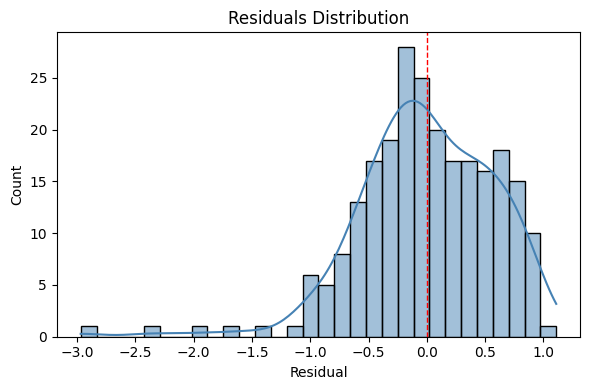

In [202]:
plot_residuals(y_test, y_pred_rf_a)

XGBoost

In [203]:
model_xgb_l = XGBRegressor()
model_xgb_l.fit(X_train_l_scaled, y_train)
y_pred_xgb_l = model_xgb_l.predict(X_test_l_scaled)

In [204]:
evaluate_regression_metrics_df(y_test, y_pred_xgb_l)

,Metryka,Wartość
0,MSE,0.6094
1,RMSE,0.7806
2,RMSPE [%],35.0427
3,MAE,0.4697
4,MAPE [%],17.9389
5,R²,0.1978
6,Korelacja Pearsona,0.4804


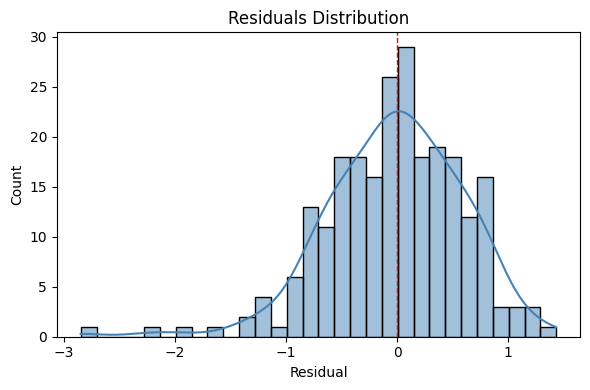

In [205]:
plot_residuals(y_test, y_pred_xgb_l)

In [206]:
model_xgb_a = XGBRegressor()
model_xgb_a.fit(X_train_a_scaled, y_train)
y_pred_xgb_a = model_xgb_a.predict(X_test_a_scaled)

In [207]:
evaluate_regression_metrics_df(y_test, y_pred_xgb_a)

,Metryka,Wartość
0,MSE,0.6230
1,RMSE,0.7893
2,RMSPE [%],37.6848
3,MAE,0.4693
4,MAPE [%],18.2251
5,R²,0.1615
6,Korelacja Pearsona,0.4435


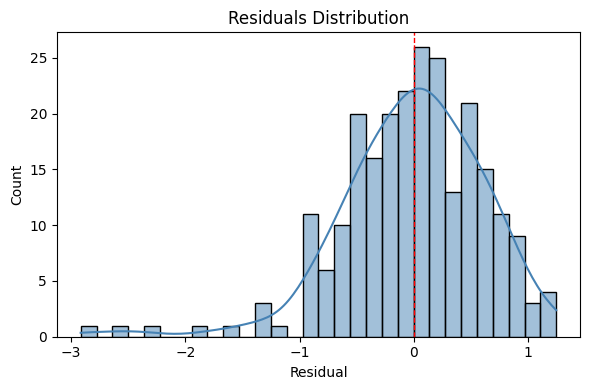

In [208]:
plot_residuals(y_test, y_pred_xgb_a)

SVR

In [209]:
model_svr_l = SVR()
model_svr_l.fit(X_train_l_scaled, y_train)
y_pred_svr_l = model_svr_l.predict(X_test_l_scaled)

In [210]:
evaluate_regression_metrics_df(y_test, y_pred_svr_l)

,Metryka,Wartość
0,MSE,0.6088
1,RMSE,0.7803
2,RMSPE [%],38.2999
3,MAE,0.4410
4,MAPE [%],17.4894
5,R²,0.1993
6,Korelacja Pearsona,0.4524


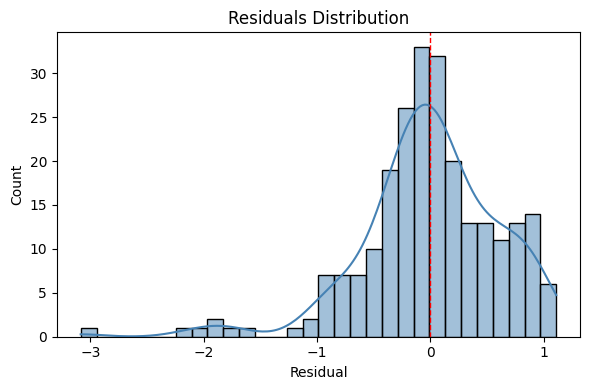

In [211]:
plot_residuals(y_test, y_pred_svr_l)

In [212]:
model_svr_a = SVR()
model_svr_a.fit(X_train_a_scaled, y_train)
y_pred_svr_a = model_svr_a.predict(X_test_a_scaled)

In [213]:
evaluate_regression_metrics_df(y_test, y_pred_svr_a)

,Metryka,Wartość
0,MSE,0.6043
1,RMSE,0.7774
2,RMSPE [%],38.0832
3,MAE,0.4421
4,MAPE [%],17.5112
5,R²,0.2111
6,Korelacja Pearsona,0.4644


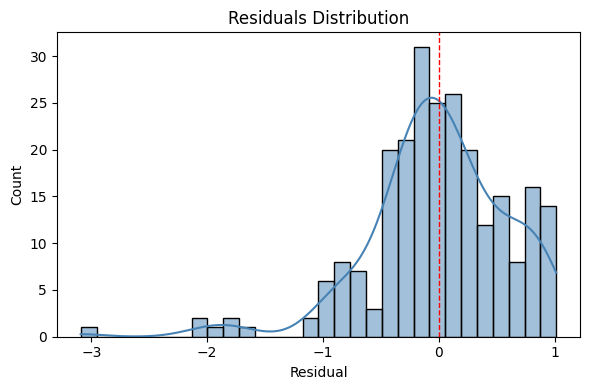

In [214]:
plot_residuals(y_test, y_pred_svr_a)

K-Nearest Neighbors Regressor

In [215]:
model_knn_l = KNeighborsRegressor()
model_knn_l.fit(X_train_l_scaled, y_train)
y_pred_knn_l = model_knn_l.predict(X_test_l_scaled)

In [216]:
evaluate_regression_metrics_df(y_test, y_pred_knn_l)

,Metryka,Wartość
0,MSE,0.5965
1,RMSE,0.7724
2,RMSPE [%],35.9069
3,MAE,0.4282
4,MAPE [%],16.8050
5,R²,0.2313
6,Korelacja Pearsona,0.4870


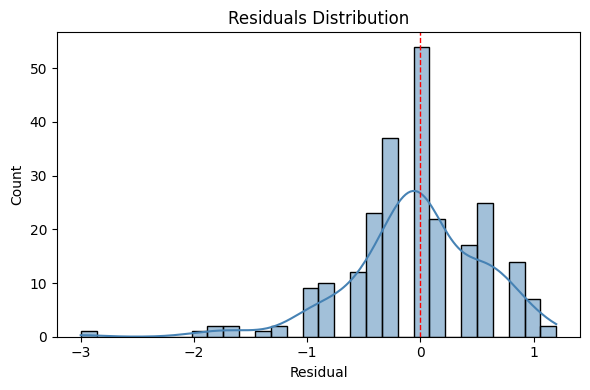

In [217]:
plot_residuals(y_test, y_pred_knn_l)

In [218]:
model_knn_a = KNeighborsRegressor()
model_knn_a.fit(X_train_a_scaled, y_train)
y_pred_knn_a = model_knn_a.predict(X_test_a_scaled)

In [219]:
evaluate_regression_metrics_df(y_test, y_pred_knn_a)

,Metryka,Wartość
0,MSE,0.6073
1,RMSE,0.7793
2,RMSPE [%],36.6327
3,MAE,0.4448
4,MAPE [%],17.4136
5,R²,0.2033
6,Korelacja Pearsona,0.4583


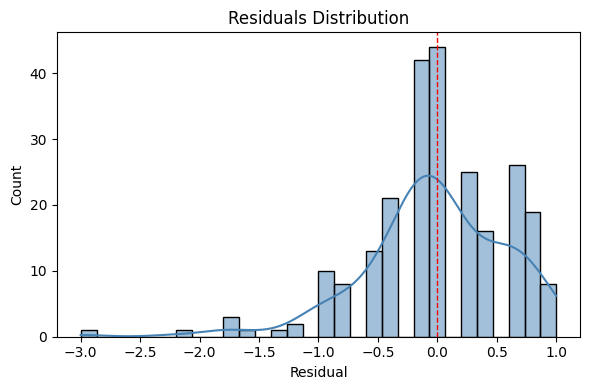

In [220]:
plot_residuals(y_test, y_pred_knn_a)

LassoCV

In [221]:
model_lasso_l = LassoCV()
model_lasso_l.fit(X_train_l_scaled, y_train)
y_pred_lasso_l = model_lasso_l.predict(X_test_l_scaled)

In [222]:
evaluate_regression_metrics_df(y_test, y_pred_lasso_l)

,Metryka,Wartość
0,MSE,0.5637
1,RMSE,0.7508
2,RMSPE [%],33.9379
3,MAE,0.4400
4,MAPE [%],16.8314
5,R²,0.3136
6,Korelacja Pearsona,0.5617


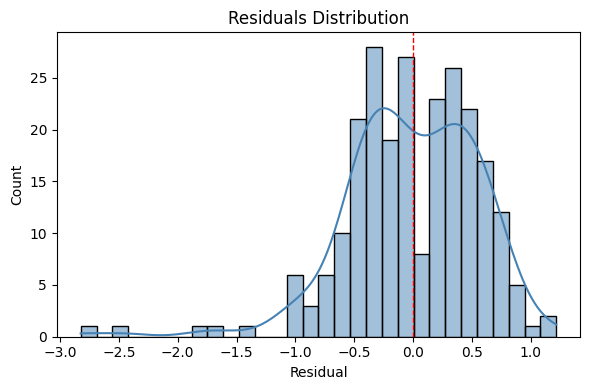

In [223]:
plot_residuals(y_test, y_pred_lasso_l)

In [224]:
model_lasso_a = LassoCV()
model_lasso_a.fit(X_train_a_scaled, y_train)
y_pred_lasso_a = model_lasso_a.predict(X_test_a_scaled)

In [225]:
evaluate_regression_metrics_df(y_test, y_pred_lasso_a)

,Metryka,Wartość
0,MSE,0.5635
1,RMSE,0.7506
2,RMSPE [%],33.9456
3,MAE,0.4398
4,MAPE [%],16.8285
5,R²,0.3141
6,Korelacja Pearsona,0.5623


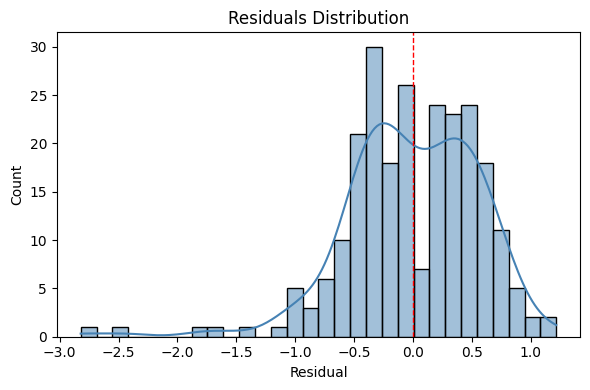

In [226]:
plot_residuals(y_test, y_pred_lasso_a)

Ridge

In [227]:
model_ridge_l = Ridge()
model_ridge_l.fit(X_train_l_scaled, y_train)
y_pred_ridge_l = model_ridge_l.predict(X_test_l_scaled)

In [228]:
evaluate_regression_metrics_df(y_test, y_pred_ridge_l)

,Metryka,Wartość
0,MSE,0.5631
1,RMSE,0.7504
2,RMSPE [%],33.6430
3,MAE,0.4378
4,MAPE [%],16.6894
5,R²,0.3151
6,Korelacja Pearsona,0.5616


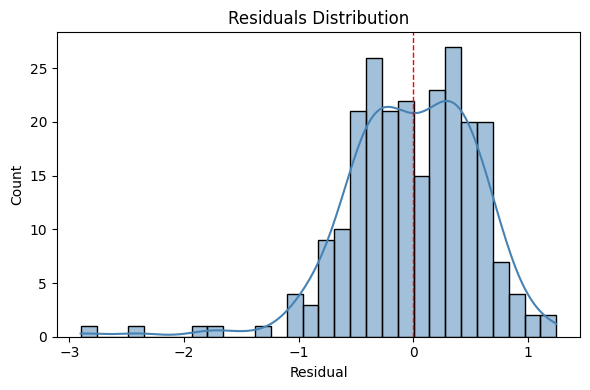

In [229]:
plot_residuals(y_test, y_pred_ridge_l)

In [230]:
model_ridge_a = Ridge()
model_ridge_a.fit(X_train_a_scaled, y_train)
y_pred_ridge_a = model_ridge_a.predict(X_test_a_scaled)

In [231]:
evaluate_regression_metrics_df(y_test, y_pred_ridge_a)

,Metryka,Wartość
0,MSE,0.5628
1,RMSE,0.7502
2,RMSPE [%],33.6968
3,MAE,0.4373
4,MAPE [%],16.7004
5,R²,0.3158
6,Korelacja Pearsona,0.5622


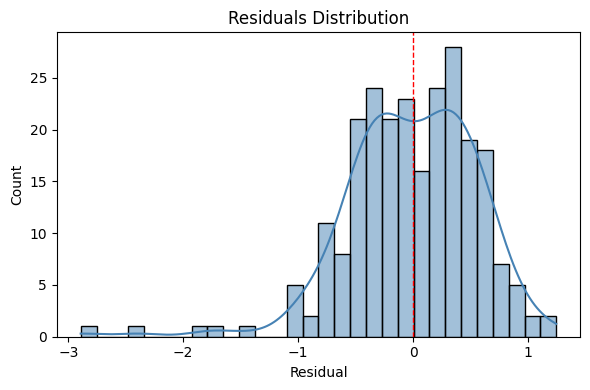

In [232]:
plot_residuals(y_test, y_pred_ridge_a)

Gradient Boosting Regressor

In [233]:
model_gbr_l = GradientBoostingRegressor()
model_gbr_l.fit(X_train_l_scaled, y_train)
y_pred_gbr_l = model_gbr_l.predict(X_test_l_scaled)

In [234]:
evaluate_regression_metrics_df(y_test, y_pred_gbr_l)

,Metryka,Wartość
0,MSE,0.5791
1,RMSE,0.7610
2,RMSPE [%],34.2518
3,MAE,0.4429
4,MAPE [%],16.9284
5,R²,0.2755
6,Korelacja Pearsona,0.5330


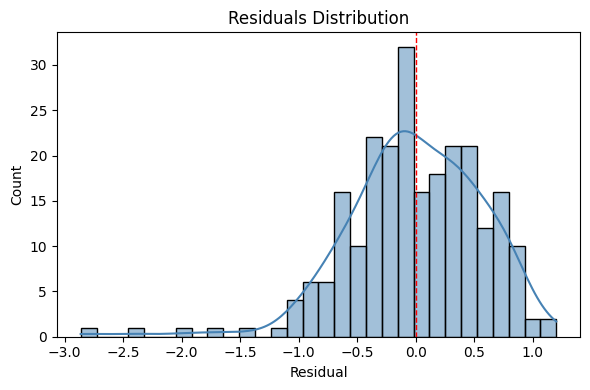

In [235]:
plot_residuals(y_test, y_pred_gbr_l)

In [236]:
model_gbr_a = GradientBoostingRegressor()
model_gbr_a.fit(X_train_a_scaled, y_train)
y_pred_gbr_a = model_gbr_a.predict(X_test_a_scaled)

In [237]:
evaluate_regression_metrics_df(y_test, y_pred_gbr_a)

,Metryka,Wartość
0,MSE,0.5777
1,RMSE,0.7601
2,RMSPE [%],34.7128
3,MAE,0.4362
4,MAPE [%],16.7392
5,R²,0.2790
6,Korelacja Pearsona,0.5324


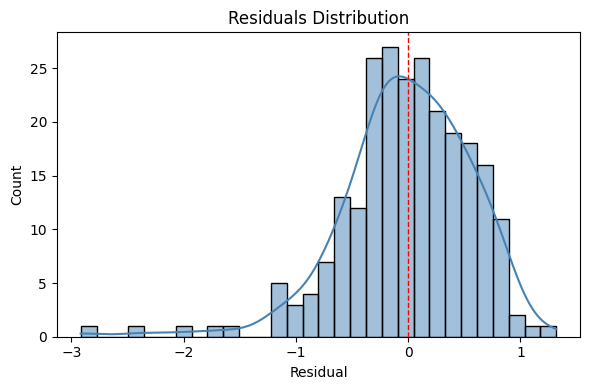

In [238]:
plot_residuals(y_test, y_pred_gbr_a)

Elastic Net

In [239]:
model_enc_l = ElasticNetCV()
model_enc_l.fit(X_train_l_scaled, y_train)
y_pred_enc_l = model_enc_l.predict(X_test_l_scaled)

In [240]:
evaluate_regression_metrics_df(y_test, y_pred_enc_l)

,Metryka,Wartość
0,MSE,0.5638
1,RMSE,0.7509
2,RMSPE [%],33.9704
3,MAE,0.4401
4,MAPE [%],16.8412
5,R²,0.3133
6,Korelacja Pearsona,0.5617


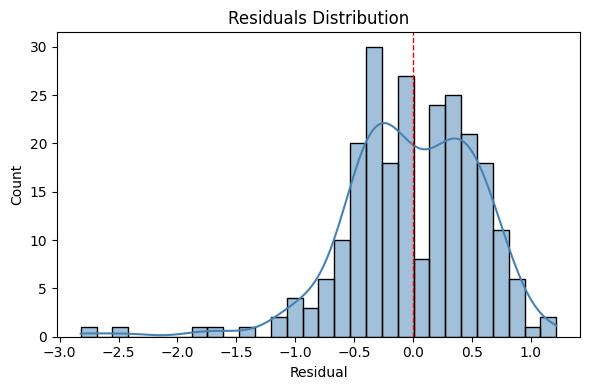

In [241]:
plot_residuals(y_test, y_pred_enc_l)

In [242]:
model_enc_a = ElasticNetCV()
model_enc_a.fit(X_train_a_scaled, y_train)
y_pred_enc_a = model_enc_a.predict(X_test_a_scaled)

In [243]:
evaluate_regression_metrics_df(y_test, y_pred_enc_a)

,Metryka,Wartość
0,MSE,0.5635
1,RMSE,0.7507
2,RMSPE [%],33.9638
3,MAE,0.4396
4,MAPE [%],16.8277
5,R²,0.3140
6,Korelacja Pearsona,0.5622


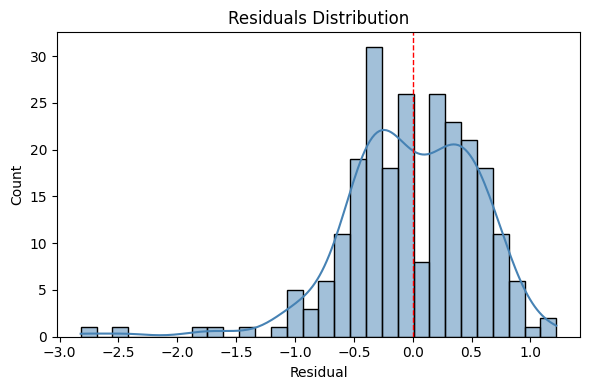

In [244]:
plot_residuals(y_test, y_pred_enc_a)

# 8. Model Comparison

In [245]:
models = {
    "Linear Regression": ("model_reg_l", "model_reg_a"),
    "Random Forest": ("model_rf_l", "model_rf_a"),
    "XGBoost": ("model_xgb_l", "model_xgb_a"),
    "SVR": ("model_svr_l", "model_svr_a"),
    "K-Nearest Neighbors": ("model_knn_l", "model_knn_a"),
    "LassoCV": ("model_lasso_l", "model_lasso_a"),
    "Ridge": ("model_ridge_l", "model_ridge_a"),
    "Gradient Boosting": ("model_gbr_l", "model_gbr_a"),
    "Elastic Net CV": ("model_enc_l", "model_enc_a")
    }

In [246]:
X_tests = {
    "_l": X_test_l_scaled,
    "_a": X_test_a_scaled
}

In [247]:
y_test_vals = y_test.values

In [248]:
results = []

In [249]:
for model_name, (model_l_var, model_a_var) in models.items():
    for suffix, X_test_curr, model_var_name in [
        ("_l", X_tests["_l"], model_l_var),
        ("_a", X_tests["_a"], model_a_var)
    ]:
        model_obj = globals()[model_var_name]
        y_pred = model_obj.predict(X_test_curr)
        
        diffs = y_test_vals - y_pred
        rmse = np.sqrt(np.mean(diffs**2))
        mae = np.mean(np.abs(diffs))
        r2 = r2_score(y_test_vals, y_pred)
        pearson_r = np.corrcoef(y_test_vals, y_pred)[0, 1]
        
        results.append({
            "Model": model_name,
            "Predictor Set": "Likert-only" if suffix == "_l" else "Likert+Salary",
            "R2": round(r2, 3),
            "RMSE": round(rmse, 3),
            "MAE": round(mae, 3),
            "Pearson r": round(pearson_r, 3)
        })

In [250]:
results_df = pd.DataFrame(results)
results_df

,Model,Predictor Set,R2,RMSE,MAE,Pearson r
0,Linear Regression,Likert-only,0.315,0.563,0.438,0.562
1,Linear Regression,Likert+Salary,0.316,0.563,0.437,0.562
2,Random Forest,Likert-only,0.247,0.590,0.453,0.502
3,Random Forest,Likert+Salary,0.268,0.582,0.446,0.520
4,XGBoost,Likert-only,0.198,0.609,0.470,0.480
5,XGBoost,Likert+Salary,0.161,0.623,0.469,0.443
6,SVR,Likert-only,0.199,0.609,0.441,0.452
7,SVR,Likert+Salary,0.211,0.604,0.442,0.464
8,K-Nearest Neighbors,Likert-only,0.231,0.597,0.428,0.487
9,K-Nearest Neighbors,Likert+Salary,0.203,0.607,0.445,0.458


In [251]:
results_df = pd.DataFrame(results).sort_values(by="R2", ascending=False)
results_df

,Model,Predictor Set,R2,RMSE,MAE,Pearson r
1,Linear Regression,Likert+Salary,0.316,0.563,0.437,0.562
13,Ridge,Likert+Salary,0.316,0.563,0.437,0.562
0,Linear Regression,Likert-only,0.315,0.563,0.438,0.562
12,Ridge,Likert-only,0.315,0.563,0.438,0.562
10,LassoCV,Likert-only,0.314,0.564,0.440,0.562
11,LassoCV,Likert+Salary,0.314,0.563,0.440,0.562
17,Elastic Net CV,Likert+Salary,0.314,0.564,0.440,0.562
16,Elastic Net CV,Likert-only,0.313,0.564,0.440,0.562
15,Gradient Boosting,Likert+Salary,0.279,0.578,0.436,0.532
14,Gradient Boosting,Likert-only,0.276,0.579,0.443,0.533


Key observations: given the linear models' superior performance, data is mostly linear. The difference between linear regression and regularized models like LassoCV, Ridge is negligible. Complex models are performing significantly worse, meaning non-linearity is most likely noise. Salary feature has a small yet positive effect. Overall R2 is low, which is to be expected in social sciences. Multicollinearity is likely not a significant problem here.

In [252]:
models_to_plot = {
    "Linear Regression": (model_reg_a, X_test_a_scaled),
    "Ridge": (model_ridge_a, X_test_a_scaled),
    "LassoCV": (model_lasso_a, X_test_a_scaled),
    "Gradient Boosting": (model_gbr_a, X_test_a_scaled)
}

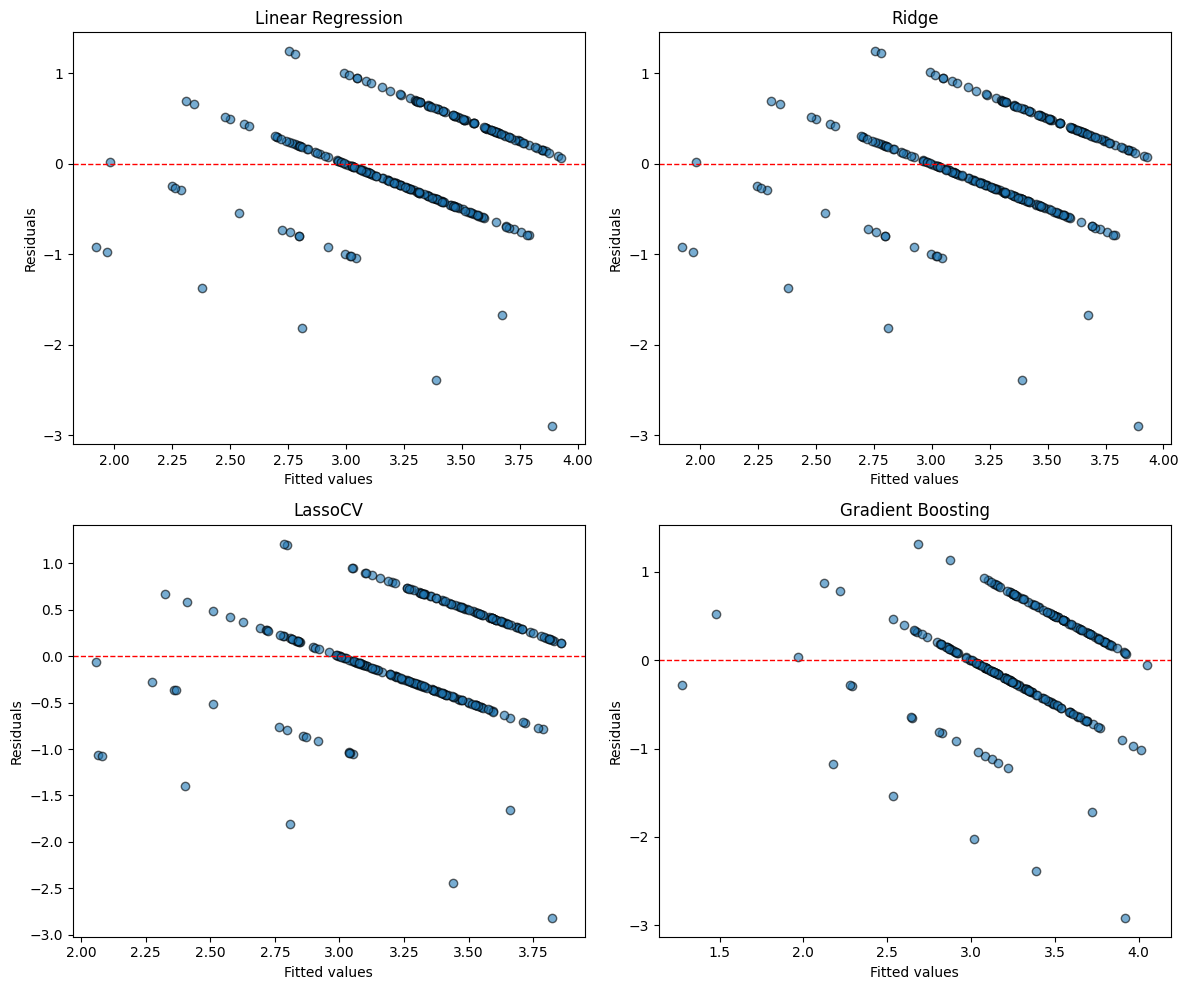

In [253]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, (name, (model, X_test)) in zip(axes, models_to_plot.items()):
    y_pred = model.predict(X_test)
    residuals = y_test.values - y_pred
    
    ax.scatter(y_pred, residuals, alpha=0.6, edgecolor='k')
    ax.axhline(0, color='red', linestyle='--', linewidth=1)
    ax.set_xlabel("Fitted values")
    ax.set_ylabel("Residuals")
    ax.set_title(name)

plt.tight_layout()
plt.show()

Residuals and fitted value distributions indicate a potential omitted variable bias, potentially a categorical variable with 2-4 values. Running a Ramsey test to verify this:

In [254]:
model = sm.OLS(y_train, X_train_all).fit()
sm.stats.durbin_watson(model.resid)  
sm.stats.linear_reset(model, power=2, use_f=True)  

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=37.356606397407134, p=1.4433819842064717e-09, df_denom=934, df_num=1>

The Ramsey RESET test (F = 59.0, p < 0.001) indicated potential model mis-specification, suggesting that nonlinear effects or omitted variables may influence the dependent variable.

Checking potential omitted variables

Gender

In [255]:
X_all_gender = df_clean[likert_predictors + salary_predictor + ["g8"]]

In [256]:
X_train_ag, X_test_ag, y_train, y_test = train_test_split(
    X_all_gender, y, test_size=0.2, random_state=42
)

In [257]:
model_reg_ag = LinearRegression()
model_reg_ag.fit(X_train_ag, y_train)
y_pred_reg_ag = model_reg_ag.predict(X_test_ag)

In [258]:
evaluate_regression_metrics_df(y_test, y_pred_reg_ag)

,Metryka,Wartość
0,MSE,0.5631
1,RMSE,0.7504
2,RMSPE [%],33.7354
3,MAE,0.4375
4,MAPE [%],16.7110
5,R²,0.3149
6,Korelacja Pearsona,0.5615


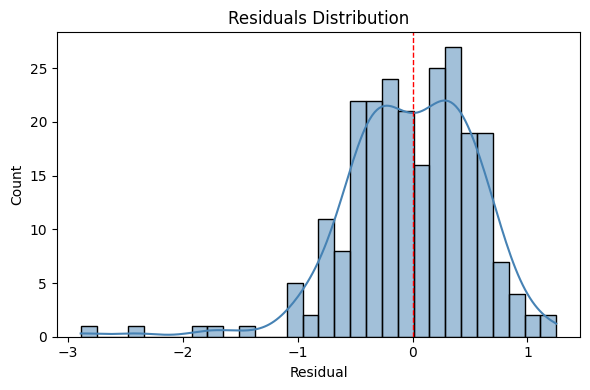

In [259]:
plot_residuals(y_test, y_pred_reg_ag)

Given the exploratory and pedagogical scope of this project, the current model is considered an acceptable approximation, with omitted variable analysis marked for future refinement.

# 9. Hyperparameter tuning

In [260]:
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
model_ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring='r2')
model_ridge_cv.fit(X_train_a_scaled, y_train)

print("Best alpha:", model_ridge_cv.alpha_)
print("CV R²:", model_ridge_cv.best_score_)
print("Test R²:", model_ridge_cv.score(X_test_a_scaled, y_test))

Best alpha: 100.0
CV R²: 0.3214414055508305
Test R²: 0.3147588051214725


In [261]:
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99, 1]
alphas = [0.001, 0.01, 0.1, 1, 10, 100]

# Fit ElasticNetCV
enet_cv = ElasticNetCV(l1_ratio=l1_ratios, alphas=alphas, cv=5, random_state=42)
enet_cv.fit(X_train_a_scaled, y_train)

# Results
print("Best alpha:", enet_cv.alpha_)
print("Best l1_ratio:", enet_cv.l1_ratio_)
print("CV R²:", enet_cv.score(X_train_a_scaled, y_train))
print("Test R²:", enet_cv.score(X_test_a_scaled, y_test))

Best alpha: 0.01
Best l1_ratio: 1.0
CV R²: 0.3699594688665634
Test R²: 0.31440704757750104


Deciding on the model

In [262]:
results = []

results.append({
    "Model": "Linear Regression",
    "Best α": None,
    "Best l1_ratio": None,
    "CV R²": None,
    "Test R²": r2_score(y_test, y_pred_reg_a),
    "RMSE": root_mean_squared_error(y_test, y_pred_reg_a),
    "MAE": mean_absolute_error(y_test, y_pred_reg_a),
    "Pearson r": np.corrcoef(y_test, y_pred_reg_a)[0, 1]
})

results.append({
    "Model": "Ridge (Baseline)",
    "Best α": getattr(model_ridge_a, "alpha", None),
    "Best l1_ratio": None,
    "CV R²": None,
    "Test R²": r2_score(y_test, y_pred_ridge_a),
    "RMSE": root_mean_squared_error(y_test, y_pred_ridge_a),
    "MAE": mean_absolute_error(y_test, y_pred_ridge_a),
    "Pearson r": np.corrcoef(y_test, y_pred_ridge_a)[0, 1]
})

results.append({
    "Model": "RidgeCV (Tuned)",
    "Best α": model_ridge_cv.alpha_,
    "Best l1_ratio": None,
    "CV R²": model_ridge_cv.best_score_,
    "Test R²": model_ridge_cv.score(X_test_a_scaled, y_test),
    "RMSE": root_mean_squared_error(y_test, model_ridge_cv.predict(X_test_a_scaled)),
    "MAE": mean_absolute_error(y_test, model_ridge_cv.predict(X_test_a_scaled)),
    "Pearson r": np.corrcoef(y_test, model_ridge_cv.predict(X_test_a_scaled))[0, 1]
})

results.append({
    "Model": "ElasticNetCV (Tuned)",
    "Best α": enet_cv.alpha_,
    "Best l1_ratio": enet_cv.l1_ratio_,
    "CV R²": enet_cv.score(X_train_a_scaled, y_train),
    "Test R²": enet_cv.score(X_test_a_scaled, y_test),
    "RMSE": root_mean_squared_error(y_test, enet_cv.predict(X_test_a_scaled)),
    "MAE": mean_absolute_error(y_test, enet_cv.predict(X_test_a_scaled)),
    "Pearson r": np.corrcoef(y_test, enet_cv.predict(X_test_a_scaled))[0, 1]
})

df_results = pd.DataFrame(results)
df_results.style.format(precision=4)

,Model,Best α,Best l1_ratio,CV R²,Test R²,RMSE,MAE,Pearson r
0,Linear Regression,nan,nan,nan,0.3157,0.5628,0.4373,0.5622
1,Ridge (Baseline),1.0000,nan,nan,0.3158,0.5628,0.4373,0.5622
2,RidgeCV (Tuned),100.0000,nan,0.3214,0.3148,0.5632,0.4374,0.5617
3,ElasticNetCV (Tuned),0.0100,1.0000,0.3700,0.3144,0.5634,0.4390,0.5617


Selecting RidgeCV for its stability

# 10. Exporting data

In [263]:
models_path = Path("../models")
models_path.mkdir(exist_ok=True)

In [264]:
joblib.dump(model_ridge_cv, models_path / "best_model.pkl")
joblib.dump(X_train_a_scaled, models_path / "X_train_a_scaled.pkl")
joblib.dump(X_test_a_scaled, models_path / "X_test_a_scaled.pkl")
joblib.dump(X_train_all, models_path / "X_train_all.pkl")
joblib.dump(y_train, models_path / "y_train.pkl")

['..\\models\\y_train.pkl']